# Análisis de Clustering: Estabilidad Matrimonial en Guatemala
## Patrones Departamentales y Tendencias Temporales (2011-2021)

---

#### **Análisis 1: Clustering Geográfico de Estabilidad Matrimonial**
**Pregunta de investigación:** ¿Existen grupos de departamentos con patrones similares de estabilidad matrimonial, considerando la tasa de divorcios respecto a matrimonios y las edades al divorcio?

**Hipótesis:** Los departamentos con mayor desarrollo urbano tienen tasas de divorcio más altas y edades de divorcio más elevadas.

#### **Análisis 2: Clustering Temporal de Tendencias**
**Pregunta de investigación:** ¿Ha cambiado la relación divorcios/matrimonios durante la década 2011-2021, reflejando transformaciones sociales?

**Hipótesis:** La tasa de divorcios respecto a matrimonios ha aumentado progresivamente, mostrando una transformación en los patrones de estabilidad matrimonial.

---

### Metodología

Para ambos análisis utilizaremos:
1. **K-Means Clustering** - Para identificar grupos naturales
2. **Método del Codo + Silhouette Score** - Para determinar K óptimo
3. **Análisis estadístico descriptivo** - Para caracterizar los clusters
4. **Visualizaciones profesionales** - Para comunicar hallazgos

---

## 1. Configuración Inicial y Carga de Librerías

In [31]:
# Librerías para manipulación de datos
import pandas as pd
import numpy as np

# Librerías para visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import matplotlib.patches as mpatches

# Librerías para análisis estadístico
from scipy import stats
from scipy.stats import pearsonr, spearmanr

# Librerías para clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Configuración
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✓ Librerías cargadas correctamente")

✓ Librerías cargadas correctamente


## 2. Carga y Preparación de Datos

In [32]:
# Cargar datasets
divorcios = pd.read_csv('div_full.csv', encoding='utf-8')
matrimonios = pd.read_csv('mat_full.csv', encoding='utf-8')

print(f"✓ Divorcios cargados: {divorcios.shape[0]:,} registros, {divorcios.shape[1]} variables")
print(f"✓ Matrimonios cargados: {matrimonios.shape[0]:,} registros, {matrimonios.shape[1]} variables")

✓ Divorcios cargados: 56,349 registros, 12 variables
✓ Matrimonios cargados: 752,264 registros, 15 variables


In [33]:
# Mapeo de departamentos para limpieza
mapeo_departamentos = {
    'Guatemala': 'Guatemala',
    'Quetzaltenango': 'Quetzaltenango',
    'Escuintla': 'Escuintla',
    'Jutiapa': 'Jutiapa',
    'San Marcos': 'San Marcos',
    'Izabal': 'Izabal',
    'Huehuetenango': 'Huehuetenango',
    'Suchitepequez': 'Suchitepéquez',
    'Suchitepéquez': 'Suchitepéquez',
    'Retalhuleu': 'Retalhuleu',
    'Zacapa': 'Zacapa',
    'Santa Rosa': 'Santa Rosa',
    'Chiquimula': 'Chiquimula',
    'Alta Verapaz': 'Alta Verapaz',
    'Jalapa': 'Jalapa',
    'Peten': 'Petén',
    'Petén': 'Petén',
    'Quiche': 'Quiché',
    'Quiché': 'Quiché',
    'Chimaltenango': 'Chimaltenango',
    'Sacatepequez': 'Sacatepéquez',
    'Sacatepéquez': 'Sacatepéquez',
    'Baja Verapaz': 'Baja Verapaz',
    'El Progreso': 'El Progreso',
    'Totonicapan': 'Totonicapán',
    'Totonicapán': 'Totonicapán',
    'Solola': 'Sololá',
    'Sololá': 'Sololá'
}

# Mapeo de meses
MESES_A_NUMERO = {
    'Enero': 1, 'Febrero': 2, 'Marzo': 3, 'Abril': 4,
    'Mayo': 5, 'Junio': 6, 'Julio': 7, 'Agosto': 8,
    'Septiembre': 9, 'Octubre': 10, 'Noviembre': 11, 'Diciembre': 12
}

print("✓ Diccionarios de mapeo creados")

✓ Diccionarios de mapeo creados


In [34]:
# Convertir columnas numéricas
columnas_numericas = ['AÑOREG', 'DIAOCU', 'EDADHOM', 'EDADMUJ']

print("Convirtiendo columnas numéricas - DIVORCIOS")
for col in columnas_numericas:
    if col in divorcios.columns:
        divorcios[col] = pd.to_numeric(divorcios[col], errors='coerce')
        validos = divorcios[col].notna().sum()
        print(f"  {col}: {validos}/{len(divorcios)} válidos ({validos/len(divorcios)*100:.1f}%)")

print("\nConvirtiendo columnas numéricas - MATRIMONIOS")
for col in columnas_numericas:
    if col in matrimonios.columns:
        matrimonios[col] = pd.to_numeric(matrimonios[col], errors='coerce')
        validos = matrimonios[col].notna().sum()
        print(f"  {col}: {validos}/{len(matrimonios)} válidos ({validos/len(matrimonios)*100:.1f}%)")

Convirtiendo columnas numéricas - DIVORCIOS
  AÑOREG: 56349/56349 válidos (100.0%)
  DIAOCU: 56349/56349 válidos (100.0%)
  EDADHOM: 25467/56349 válidos (45.2%)
  EDADMUJ: 25584/56349 válidos (45.4%)

Convirtiendo columnas numéricas - MATRIMONIOS
  AÑOREG: 752264/752264 válidos (100.0%)
  DIAOCU: 752264/752264 válidos (100.0%)
  EDADHOM: 751969/752264 válidos (100.0%)
  EDADMUJ: 751931/752264 válidos (100.0%)


In [35]:
# Limpiar departamentos
divorcios['DEPREG_LIMPIO'] = divorcios['DEPREG'].map(mapeo_departamentos).fillna(divorcios['DEPREG'])
matrimonios['DEPREG_LIMPIO'] = matrimonios['DEPREG'].map(mapeo_departamentos).fillna(matrimonios['DEPREG'])

# Limpiar meses
divorcios['MES_NUM'] = divorcios['MESOCU'].map(MESES_A_NUMERO)
matrimonios['MES_NUM'] = matrimonios['MESOCU'].map(MESES_A_NUMERO)

# Eliminar registros con datos faltantes críticos
divorcios = divorcios.dropna(subset=['MES_NUM', 'DEPREG_LIMPIO'])
matrimonios = matrimonios.dropna(subset=['MES_NUM', 'DEPREG_LIMPIO'])

print(f"✓ Datos limpios - Divorcios: {len(divorcios):,} registros")
print(f"✓ Datos limpios - Matrimonios: {len(matrimonios):,} registros")

✓ Datos limpios - Divorcios: 56,349 registros
✓ Datos limpios - Matrimonios: 752,264 registros


---

# ANÁLISIS 1: CLUSTERING GEOGRÁFICO POR DEPARTAMENTO

---

## 3. Preparación de Features para Clustering Geográfico

Crearemos las siguientes variables por departamento:
- **Tasa de divorcio:** Divorcios / Matrimonios × 1000
- **Edad promedio al divorcio (hombres)**
- **Edad promedio al divorcio (mujeres)**
- **Volumen total de divorcios**
- **Volumen total de matrimonios**

In [36]:
# Agregaciones por departamento - DIVORCIOS
div_por_depto = divorcios.groupby('DEPREG_LIMPIO').agg({
    'AÑOREG': 'count',  # Total de divorcios
    'EDADHOM': 'mean',  # Edad promedio hombres
    'EDADMUJ': 'mean'   # Edad promedio mujeres
}).reset_index()

div_por_depto.columns = ['Departamento', 'Total_Divorcios', 'Edad_Prom_Hom_Div', 'Edad_Prom_Muj_Div']

# Agregaciones por departamento - MATRIMONIOS
mat_por_depto = matrimonios.groupby('DEPREG_LIMPIO').agg({
    'AÑOREG': 'count'  # Total de matrimonios
}).reset_index()

mat_por_depto.columns = ['Departamento', 'Total_Matrimonios']

# Combinar ambos datasets
datos_depto = pd.merge(div_por_depto, mat_por_depto, on='Departamento', how='outer')
datos_depto = datos_depto.fillna(0)

# Calcular tasa de divorcio (por cada 1000 matrimonios)
datos_depto['Tasa_Divorcio'] = (datos_depto['Total_Divorcios'] / datos_depto['Total_Matrimonios']) * 1000

# Manejar casos de división por cero
datos_depto['Tasa_Divorcio'] = datos_depto['Tasa_Divorcio'].replace([np.inf, -np.inf], 0)

print("✓ Features por departamento creadas")
print(f"\nDepartamentos analizados: {len(datos_depto)}")
print("\nPrimeras filas:")
datos_depto.head()

✓ Features por departamento creadas

Departamentos analizados: 22

Primeras filas:


,Departamento,Total_Divorcios,Edad_Prom_Hom_Div,Edad_Prom_Muj_Div,Total_Matrimonios,Tasa_Divorcio
0,Alta Verapaz,1401,35.808068,31.893773,52734,26.567300
1,Baja Verapaz,1009,34.859406,31.326376,13953,72.314198
2,Chimaltenango,1178,34.986068,32.277863,38338,30.726694
3,Chiquimula,1407,35.214286,31.227769,16418,85.698623
4,El Progreso,996,34.581655,30.681614,8476,117.508259


In [37]:
# Estadísticas descriptivas
print("ESTADÍSTICAS DESCRIPTIVAS POR DEPARTAMENTO")
print("="*60)
print(datos_depto.describe().round(2))

ESTADÍSTICAS DESCRIPTIVAS POR DEPARTAMENTO
       Total_Divorcios  Edad_Prom_Hom_Div  Edad_Prom_Muj_Div  \
count            22.00              22.00              22.00   
mean           2561.32              35.01              31.44   
std            4476.19               1.18               1.22   
min             621.00              31.28              28.69   
25%            1252.25              34.78              30.76   
50%            1479.50              35.30              31.65   
75%            1806.25              35.79              32.27   
max           22339.00              36.38              33.30   

       Total_Matrimonios  Tasa_Divorcio  
count              22.00          22.00  
mean            34193.82          71.17  
std             31004.18          34.24  
min              8476.00          26.57  
25%             17297.25          36.37  
50%             23838.50          71.58  
75%             44551.00          91.79  
max            156705.00         142.55  


## 4. Selección de Features y Normalización (Geográfico)

In [38]:
# Seleccionar features para clustering
features_clustering_geo = ['Tasa_Divorcio', 'Edad_Prom_Hom_Div', 'Edad_Prom_Muj_Div']

# Eliminar departamentos con datos faltantes en edades
datos_depto_clean = datos_depto[datos_depto[features_clustering_geo].notna().all(axis=1)].copy()

print(f"Departamentos con datos completos: {len(datos_depto_clean)}")

# Extraer matriz de features
X_geo = datos_depto_clean[features_clustering_geo].values

# Normalizar features (Z-score)
scaler_geo = StandardScaler()
X_geo_scaled = scaler_geo.fit_transform(X_geo)

print(f"\n✓ Features normalizadas")
print(f"  Forma de la matriz: {X_geo_scaled.shape}")
print(f"  Media (debe ser ~0): {X_geo_scaled.mean(axis=0).round(4)}")
print(f"  Desviación estándar (debe ser ~1): {X_geo_scaled.std(axis=0).round(4)}")

Departamentos con datos completos: 22

✓ Features normalizadas
  Forma de la matriz: (22, 3)
  Media (debe ser ~0): [ 0. -0.  0.]
  Desviación estándar (debe ser ~1): [1. 1. 1.]


## 5. Determinación de K Óptimo (Geográfico)

Usaremos dos métodos:
1. **Método del Codo (Elbow Method):** Analiza la inercia
2. **Silhouette Score:** Mide la calidad de los clusters

In [39]:
# Rango de K a evaluar
k_range = range(2, min(10, len(datos_depto_clean)))

# Almacenar métricas
inertias_geo = []
silhouette_scores_geo = []

print("Evaluando diferentes valores de K...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_geo_scaled)
    
    inertias_geo.append(kmeans.inertia_)
    silhouette_scores_geo.append(silhouette_score(X_geo_scaled, labels))
    
    print(f"  K={k}: Inercia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores_geo[-1]:.4f}")

print("\n✓ Evaluación completada")

Evaluando diferentes valores de K...
  K=2: Inercia=33.82, Silhouette=0.5296
  K=3: Inercia=22.54, Silhouette=0.3118
  K=4: Inercia=14.81, Silhouette=0.3547
  K=5: Inercia=11.34, Silhouette=0.3907
  K=6: Inercia=8.18, Silhouette=0.3916
  K=7: Inercia=5.75, Silhouette=0.3950
  K=8: Inercia=4.71, Silhouette=0.3234
  K=9: Inercia=3.94, Silhouette=0.3263

✓ Evaluación completada


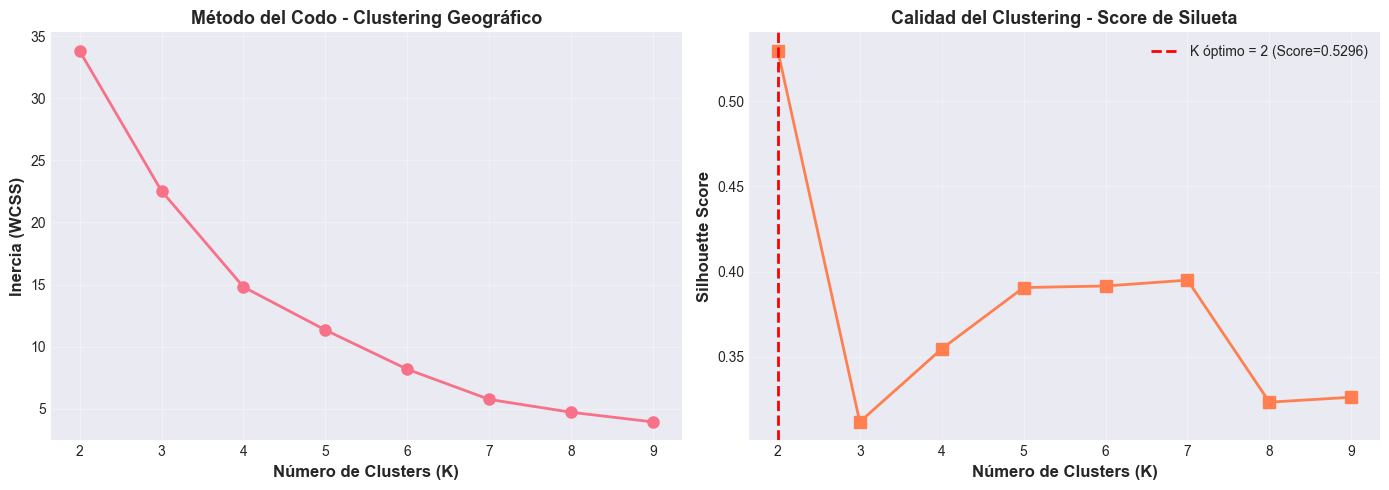


K ÓPTIMO SELECCIONADO: 2
Silhouette Score: 0.5296


In [40]:
# Visualizar método del codo y silhouette
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Método del Codo
axes[0].plot(list(k_range), inertias_geo, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Número de Clusters (K)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inercia (WCSS)', fontsize=12, fontweight='bold')
axes[0].set_title('Método del Codo - Clustering Geográfico', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(list(k_range))

# Silhouette Score
axes[1].plot(list(k_range), silhouette_scores_geo, marker='s', linewidth=2, markersize=8, color='coral')
axes[1].set_xlabel('Número de Clusters (K)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Calidad del Clustering - Score de Silueta', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(list(k_range))

# Marcar el K óptimo (mayor silhouette)
best_k_geo = list(k_range)[np.argmax(silhouette_scores_geo)]
best_silhouette_geo = max(silhouette_scores_geo)
axes[1].axvline(x=best_k_geo, color='red', linestyle='--', linewidth=2, 
                label=f'K óptimo = {best_k_geo} (Score={best_silhouette_geo:.4f})')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"K ÓPTIMO SELECCIONADO: {best_k_geo}")
print(f"Silhouette Score: {best_silhouette_geo:.4f}")
print(f"{'='*60}")

## 6. Aplicar K-Means con K Óptimo (Geográfico)

In [41]:
# Aplicar K-Means con el K óptimo
kmeans_geo_final = KMeans(n_clusters=best_k_geo, random_state=42, n_init=20)
datos_depto_clean['Cluster'] = kmeans_geo_final.fit_predict(X_geo_scaled)

# Calcular silhouette score final
silhouette_avg_geo = silhouette_score(X_geo_scaled, datos_depto_clean['Cluster'])
silhouette_values_geo = silhouette_samples(X_geo_scaled, datos_depto_clean['Cluster'])

print(f"✓ Clustering aplicado con K={best_k_geo}")
print(f"  Silhouette Score promedio: {silhouette_avg_geo:.4f}")
print(f"\nDistribución de departamentos por cluster:")
print(datos_depto_clean['Cluster'].value_counts().sort_index())

✓ Clustering aplicado con K=2
  Silhouette Score promedio: 0.5296

Distribución de departamentos por cluster:
Cluster
0    19
1     3
Name: count, dtype: int64


## 7. Interpretación de Clusters (Geográfico)

In [42]:
# Estadísticas por cluster
cluster_stats_geo = datos_depto_clean.groupby('Cluster').agg({
    'Departamento': 'count',
    'Tasa_Divorcio': ['mean', 'std'],
    'Edad_Prom_Hom_Div': ['mean', 'std'],
    'Edad_Prom_Muj_Div': ['mean', 'std'],
    'Total_Divorcios': 'sum',
    'Total_Matrimonios': 'sum'
}).round(2)

print("ESTADÍSTICAS POR CLUSTER (GEOGRÁFICO)")
print("="*80)
print(cluster_stats_geo)
print("\n")

# Departamentos en cada cluster
for cluster_id in sorted(datos_depto_clean['Cluster'].unique()):
    deptos = datos_depto_clean[datos_depto_clean['Cluster'] == cluster_id]['Departamento'].tolist()
    print(f"CLUSTER {cluster_id}: {len(deptos)} departamentos")
    print(f"  {', '.join(sorted(deptos))}")
    print()

ESTADÍSTICAS POR CLUSTER (GEOGRÁFICO)
        Departamento Tasa_Divorcio        Edad_Prom_Hom_Div        \
               count          mean    std              mean   std   
Cluster                                                             
0                 19         77.35  32.73             35.40  0.57   
1                  3         32.02   2.38             32.55  1.10   

        Edad_Prom_Muj_Div       Total_Divorcios Total_Matrimonios  
                     mean   std             sum               sum  
Cluster                                                            
0                   31.79  0.86           53340            657365  
1                   29.27  0.81            3009             94899  


CLUSTER 0: 19 departamentos
  Alta Verapaz, Baja Verapaz, Chimaltenango, Chiquimula, El Progreso, Escuintla, Guatemala, Huehuetenango, Izabal, Jalapa, Jutiapa, Petén, Quetzaltenango, Retalhuleu, Sacatepéquez, San Marcos, Santa Rosa, Suchitepéquez, Zacapa

CLUSTER 1: 3 depar

In [43]:
# Asignar nombres interpretativos a los clusters basados en características
cluster_characteristics_geo = []

for cluster_id in sorted(datos_depto_clean['Cluster'].unique()):
    cluster_data = datos_depto_clean[datos_depto_clean['Cluster'] == cluster_id]
    
    tasa_avg = cluster_data['Tasa_Divorcio'].mean()
    edad_avg = (cluster_data['Edad_Prom_Hom_Div'].mean() + cluster_data['Edad_Prom_Muj_Div'].mean()) / 2
    
    cluster_characteristics_geo.append({
        'cluster_id': cluster_id,
        'tasa': tasa_avg,
        'edad': edad_avg
    })

# Ordenar por tasa de divorcio
cluster_characteristics_geo.sort(key=lambda x: x['tasa'])

# Asignar nombres
cluster_names_geo = {}
if len(cluster_characteristics_geo) == 2:
    cluster_names_geo[cluster_characteristics_geo[0]['cluster_id']] = 'Baja Inestabilidad'
    cluster_names_geo[cluster_characteristics_geo[1]['cluster_id']] = 'Alta Inestabilidad'
elif len(cluster_characteristics_geo) == 3:
    cluster_names_geo[cluster_characteristics_geo[0]['cluster_id']] = 'Estabilidad Alta'
    cluster_names_geo[cluster_characteristics_geo[1]['cluster_id']] = 'Estabilidad Media'
    cluster_names_geo[cluster_characteristics_geo[2]['cluster_id']] = 'Estabilidad Baja'
else:
    for i, char in enumerate(cluster_characteristics_geo):
        cluster_names_geo[char['cluster_id']] = f'Grupo {i+1}'

datos_depto_clean['Cluster_Nombre'] = datos_depto_clean['Cluster'].map(cluster_names_geo)

print("NOMBRES ASIGNADOS A LOS CLUSTERS:")
for cid, name in cluster_names_geo.items():
    print(f"  Cluster {cid}: {name}")

NOMBRES ASIGNADOS A LOS CLUSTERS:
  Cluster 1: Baja Inestabilidad
  Cluster 0: Alta Inestabilidad


## 8. Visualizaciones (Geográfico)

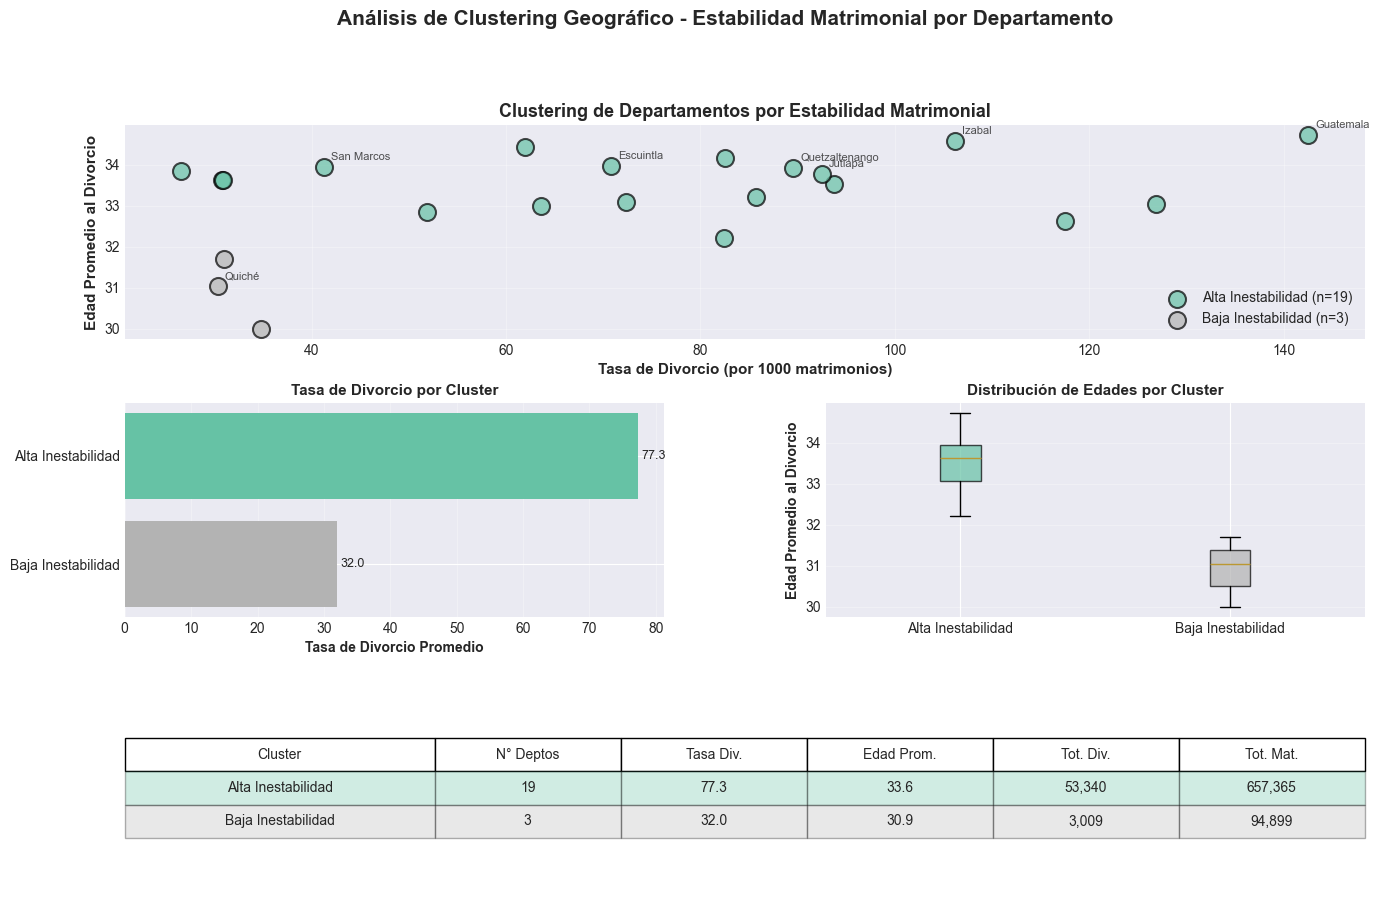

✓ Visualización geográfica generada


In [44]:
# Crear visualización completa de clusters geográficos
fig = plt.figure(figsize=(16, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# Colores por cluster
colors = plt.cm.Set2(np.linspace(0, 1, best_k_geo))
cluster_colors = {i: colors[i] for i in range(best_k_geo)}

# 1. Scatter: Tasa de Divorcio vs Edad Promedio
ax1 = fig.add_subplot(gs[0, :])
for cluster_id in sorted(datos_depto_clean['Cluster'].unique()):
    cluster_data = datos_depto_clean[datos_depto_clean['Cluster'] == cluster_id]
    ax1.scatter(
        cluster_data['Tasa_Divorcio'],
        (cluster_data['Edad_Prom_Hom_Div'] + cluster_data['Edad_Prom_Muj_Div']) / 2,
        c=[cluster_colors[cluster_id]],
        label=f"{cluster_names_geo[cluster_id]} (n={len(cluster_data)})",
        s=150,
        alpha=0.7,
        edgecolors='black',
        linewidth=1.5
    )
    
    # Anotar algunos departamentos clave
    for idx, row in cluster_data.iterrows():
        if row['Total_Divorcios'] > cluster_data['Total_Divorcios'].quantile(0.7):
            ax1.annotate(
                row['Departamento'],
                (row['Tasa_Divorcio'], (row['Edad_Prom_Hom_Div'] + row['Edad_Prom_Muj_Div']) / 2),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8,
                alpha=0.8
            )

ax1.set_xlabel('Tasa de Divorcio (por 1000 matrimonios)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Edad Promedio al Divorcio', fontsize=11, fontweight='bold')
ax1.set_title('Clustering de Departamentos por Estabilidad Matrimonial', fontsize=13, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# 2. Barplot: Tasa de divorcio por cluster
ax2 = fig.add_subplot(gs[1, 0])
cluster_means = datos_depto_clean.groupby('Cluster_Nombre')['Tasa_Divorcio'].mean().sort_values()
bars = ax2.barh(cluster_means.index, cluster_means.values, 
                color=[cluster_colors[datos_depto_clean[datos_depto_clean['Cluster_Nombre']==name]['Cluster'].iloc[0]] 
                       for name in cluster_means.index])
ax2.set_xlabel('Tasa de Divorcio Promedio', fontsize=10, fontweight='bold')
ax2.set_title('Tasa de Divorcio por Cluster', fontsize=11, fontweight='bold')
ax2.grid(True, axis='x', alpha=0.3)

# Añadir valores
for i, v in enumerate(cluster_means.values):
    ax2.text(v + 0.5, i, f'{v:.1f}', va='center', fontsize=9)

# 3. Boxplot: Distribución de edades por cluster
ax3 = fig.add_subplot(gs[1, 1])
edad_promedio = (datos_depto_clean['Edad_Prom_Hom_Div'] + datos_depto_clean['Edad_Prom_Muj_Div']) / 2
datos_depto_clean['Edad_Promedio_Div'] = edad_promedio

box_data = [datos_depto_clean[datos_depto_clean['Cluster']==c]['Edad_Promedio_Div'].values 
            for c in sorted(datos_depto_clean['Cluster'].unique())]
bp = ax3.boxplot(box_data, labels=[cluster_names_geo[c] for c in sorted(datos_depto_clean['Cluster'].unique())],
                 patch_artist=True)

for patch, cluster_id in zip(bp['boxes'], sorted(datos_depto_clean['Cluster'].unique())):
    patch.set_facecolor(cluster_colors[cluster_id])
    patch.set_alpha(0.7)

ax3.set_ylabel('Edad Promedio al Divorcio', fontsize=10, fontweight='bold')
ax3.set_title('Distribución de Edades por Cluster', fontsize=11, fontweight='bold')
ax3.grid(True, axis='y', alpha=0.3)

# 4. Tabla resumen de clusters
ax4 = fig.add_subplot(gs[2, :])
ax4.axis('tight')
ax4.axis('off')

summary_data = []
for cluster_id in sorted(datos_depto_clean['Cluster'].unique()):
    cluster_data = datos_depto_clean[datos_depto_clean['Cluster'] == cluster_id]
    summary_data.append([
        cluster_names_geo[cluster_id],
        len(cluster_data),
        f"{cluster_data['Tasa_Divorcio'].mean():.1f}",
        f"{cluster_data['Edad_Promedio_Div'].mean():.1f}",
        f"{cluster_data['Total_Divorcios'].sum():,}",
        f"{cluster_data['Total_Matrimonios'].sum():,}"
    ])

table = ax4.table(
    cellText=summary_data,
    colLabels=['Cluster', 'N° Deptos', 'Tasa Div.', 'Edad Prom.', 'Tot. Div.', 'Tot. Mat.'],
    cellLoc='center',
    loc='center',
    colWidths=[0.25, 0.15, 0.15, 0.15, 0.15, 0.15]
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Colorear filas
for i, cluster_id in enumerate(sorted(datos_depto_clean['Cluster'].unique())):
    for j in range(6):
        table[(i+1, j)].set_facecolor(cluster_colors[cluster_id])
        table[(i+1, j)].set_alpha(0.3)

plt.suptitle('Análisis de Clustering Geográfico - Estabilidad Matrimonial por Departamento',
             fontsize=15, fontweight='bold', y=0.995)

plt.show()

print("✓ Visualización geográfica generada")

## 9. Validación de Hipótesis (Geográfico)

**Hipótesis:** Los departamentos con mayor desarrollo urbano tienen tasas de divorcio más altas y edades de divorcio más elevadas.

Para validarla, analizaremos:
1. Si Guatemala (más urbano) está en el cluster de mayor tasa de divorcio
2. Si existe correlación positiva entre tasa de divorcio y edad al divorcio
3. Patrones de los clusters identificados

In [45]:
print("="*80)
print("VALIDACIÓN DE HIPÓTESIS GEOGRÁFICA")
print("="*80)

# 1. Verificar cluster de Guatemala
guatemala_cluster = datos_depto_clean[datos_depto_clean['Departamento'] == 'Guatemala']['Cluster'].iloc[0]
guatemala_cluster_name = cluster_names_geo[guatemala_cluster]
guatemala_tasa = datos_depto_clean[datos_depto_clean['Departamento'] == 'Guatemala']['Tasa_Divorcio'].iloc[0]

print(f"\n1. DEPARTAMENTO DE GUATEMALA:")
print(f"   Cluster: {guatemala_cluster_name}")
print(f"   Tasa de divorcio: {guatemala_tasa:.2f} (por 1000 matrimonios)")

# Comparar con el promedio
tasa_promedio = datos_depto_clean['Tasa_Divorcio'].mean()
if guatemala_tasa > tasa_promedio:
    print(f"   ✓ Guatemala tiene tasa SUPERIOR al promedio ({tasa_promedio:.2f})")
    validacion_geo_1 = True
else:
    print(f"   ✗ Guatemala tiene tasa INFERIOR al promedio ({tasa_promedio:.2f})")
    validacion_geo_1 = False

# 2. Correlación entre tasa de divorcio y edad
print(f"\n2. ANÁLISIS DE CORRELACIÓN:")
corr_tasa_edad, p_value = pearsonr(
    datos_depto_clean['Tasa_Divorcio'],
    datos_depto_clean['Edad_Promedio_Div']
)
print(f"   Correlación (Tasa vs Edad): r={corr_tasa_edad:.4f}, p={p_value:.4f}")

if corr_tasa_edad > 0 and p_value < 0.05:
    print(f"   ✓ Correlación POSITIVA significativa")
    validacion_geo_2 = True
elif corr_tasa_edad > 0:
    print(f"   ⚠️ Correlación positiva pero no significativa (p>{0.05})")
    validacion_geo_2 = False
else:
    print(f"   ✗ No hay correlación positiva")
    validacion_geo_2 = False

# 3. Características de clusters
print(f"\n3. PATRONES DE CLUSTERS:")
cluster_mas_alto = datos_depto_clean.groupby('Cluster')['Tasa_Divorcio'].mean().idxmax()
cluster_mas_alto_nombre = cluster_names_geo[cluster_mas_alto]
deptos_cluster_alto = datos_depto_clean[datos_depto_clean['Cluster'] == cluster_mas_alto]['Departamento'].tolist()

print(f"   Cluster con mayor tasa: {cluster_mas_alto_nombre}")
print(f"   Departamentos: {', '.join(deptos_cluster_alto)}")

# Verificar si los departamentos más urbanos están ahí
urbanos = ['Guatemala', 'Sacatepéquez', 'Quetzaltenango']
urbanos_en_cluster = [d for d in urbanos if d in deptos_cluster_alto]

if len(urbanos_en_cluster) >= 2:
    print(f"   ✓ Departamentos urbanos en este cluster: {', '.join(urbanos_en_cluster)}")
    validacion_geo_3 = True
else:
    print(f"   ✗ Pocos departamentos urbanos en este cluster")
    validacion_geo_3 = False

# 4. Conclusión
validaciones_geo = [validacion_geo_1, validacion_geo_2, validacion_geo_3]
porcentaje_validacion_geo = (sum(validaciones_geo) / len(validaciones_geo)) * 100

print(f"\n{'='*80}")
print(f"CONCLUSIÓN HIPÓTESIS GEOGRÁFICA")
print(f"{'='*80}")
print(f"Criterios validados: {sum(validaciones_geo)}/{len(validaciones_geo)} ({porcentaje_validacion_geo:.1f}%)")

if porcentaje_validacion_geo >= 66:
    print(f"\n✓ HIPÓTESIS CONFIRMADA")
    print("Los departamentos con mayor desarrollo urbano muestran tasas de divorcio")
    print("más altas y edades al divorcio más elevadas.")
elif porcentaje_validacion_geo >= 33:
    print(f"\n⚠️ HIPÓTESIS PARCIALMENTE CONFIRMADA")
    print("Existe evidencia parcial del patrón esperado.")
else:
    print(f"\n✗ HIPÓTESIS REFUTADA")
    print("No se encontró evidencia suficiente del patrón esperado.")

VALIDACIÓN DE HIPÓTESIS GEOGRÁFICA

1. DEPARTAMENTO DE GUATEMALA:
   Cluster: Alta Inestabilidad
   Tasa de divorcio: 142.55 (por 1000 matrimonios)
   ✓ Guatemala tiene tasa SUPERIOR al promedio (71.17)

2. ANÁLISIS DE CORRELACIÓN:
   Correlación (Tasa vs Edad): r=0.3976, p=0.0669
   ⚠️ Correlación positiva pero no significativa (p>0.05)

3. PATRONES DE CLUSTERS:
   Cluster con mayor tasa: Alta Inestabilidad
   Departamentos: Alta Verapaz, Baja Verapaz, Chimaltenango, Chiquimula, El Progreso, Escuintla, Guatemala, Huehuetenango, Izabal, Jalapa, Jutiapa, Petén, Quetzaltenango, Retalhuleu, Sacatepéquez, San Marcos, Santa Rosa, Suchitepéquez, Zacapa
   ✓ Departamentos urbanos en este cluster: Guatemala, Sacatepéquez, Quetzaltenango

CONCLUSIÓN HIPÓTESIS GEOGRÁFICA
Criterios validados: 2/3 (66.7%)

✓ HIPÓTESIS CONFIRMADA
Los departamentos con mayor desarrollo urbano muestran tasas de divorcio
más altas y edades al divorcio más elevadas.


---

# ANÁLISIS 2: CLUSTERING TEMPORAL DE TENDENCIAS

---

## 10. Preparación de Features para Clustering Temporal

Crearemos las siguientes variables por año:
- **Tasa de divorcio anual:** Divorcios / Matrimonios × 1000
- **Volumen de divorcios**
- **Volumen de matrimonios**
- **Tendencia temporal** (para identificar períodos)

In [46]:
# Agregaciones por año - DIVORCIOS
div_por_anio = divorcios.groupby('AÑOREG').agg({
    'DEPREG_LIMPIO': 'count',  # Total de divorcios (usando otra columna)
    'EDADHOM': 'mean',  # Edad promedio hombres
    'EDADMUJ': 'mean'   # Edad promedio mujeres
}).reset_index()

div_por_anio.columns = ['Anio', 'Total_Divorcios', 'Edad_Prom_Hom_Div', 'Edad_Prom_Muj_Div']

# Agregaciones por año - MATRIMONIOS
mat_por_anio = matrimonios.groupby('AÑOREG').agg({
    'DEPREG_LIMPIO': 'count',  # Total de matrimonios (usando otra columna)
    'EDADHOM': 'mean',
    'EDADMUJ': 'mean'
}).reset_index()

mat_por_anio.columns = ['Anio', 'Total_Matrimonios', 'Edad_Prom_Hom_Mat', 'Edad_Prom_Muj_Mat']

# Combinar ambos datasets
datos_temporales = pd.merge(div_por_anio, mat_por_anio, on='Anio', how='outer')
datos_temporales = datos_temporales.fillna(0)

# Calcular tasa de divorcio
datos_temporales['Tasa_Divorcio'] = (datos_temporales['Total_Divorcios'] / 
                                      datos_temporales['Total_Matrimonios']) * 1000
datos_temporales['Tasa_Divorcio'] = datos_temporales['Tasa_Divorcio'].replace([np.inf, -np.inf], 0)

# Ordenar por año
datos_temporales = datos_temporales.sort_values('Anio').reset_index(drop=True)

print("✓ Features temporales creadas")
print(f"\nPeríodo analizado: {datos_temporales['Anio'].min():.0f} - {datos_temporales['Anio'].max():.0f}")
print(f"Total de años: {len(datos_temporales)}")
print("\nDatos completos:")
datos_temporales

✓ Features temporales creadas

Período analizado: 2011 - 2021
Total de años: 11

Datos completos:


,Anio,Total_Divorcios,Edad_Prom_Hom_Div,Edad_Prom_Muj_Div,Total_Matrimonios,Edad_Prom_Hom_Mat,Edad_Prom_Muj_Mat,Tasa_Divorcio
0,2011.0,3370,35.608247,32.243434,70126,28.211721,25.109834,48.056356
1,2012.0,4927,35.722830,32.192523,80943,28.802538,25.674524,60.869995
2,2013.0,5581,35.168215,31.593607,82602,28.722691,25.598345,67.564950
3,2014.0,5392,35.191518,31.818141,79984,28.961343,25.818110,67.413483
4,2015.0,5735,34.910788,31.371853,81544,28.776029,25.708658,70.330129
5,2016.0,5674,34.948499,31.511997,70403,30.146374,27.268937,80.593157
6,2017.0,5694,35.521319,31.950380,70834,30.016561,27.191662,80.385126
7,2018.0,6158,35.460297,32.245098,74952,30.165399,27.290186,82.159249
8,2019.0,8430,35.852143,32.820412,76148,30.078624,27.186838,110.705468
9,2020.0,4102,36.424823,33.135169,57207,29.986680,27.080166,71.704512


In [47]:
# Agregaciones por año - DIVORCIOS
div_por_anio = divorcios.groupby('AÑOREG').agg({
    'DEPREG_LIMPIO': 'count',  # Total de divorcios (usando otra columna)
    'EDADHOM': 'mean',  # Edad promedio hombres
    'EDADMUJ': 'mean'   # Edad promedio mujeres
}).reset_index()

div_por_anio.columns = ['Anio', 'Total_Divorcios', 'Edad_Prom_Hom_Div', 'Edad_Prom_Muj_Div']

# Agregaciones por año - MATRIMONIOS
mat_por_anio = matrimonios.groupby('AÑOREG').agg({
    'DEPREG_LIMPIO': 'count',  # Total de matrimonios (usando otra columna)
    'EDADHOM': 'mean',
    'EDADMUJ': 'mean'
}).reset_index()

mat_por_anio.columns = ['Anio', 'Total_Matrimonios', 'Edad_Prom_Hom_Mat', 'Edad_Prom_Muj_Mat']

# Combinar ambos datasets
datos_temporales = pd.merge(div_por_anio, mat_por_anio, on='Anio', how='outer')
datos_temporales = datos_temporales.fillna(0)

# Calcular tasa de divorcio
datos_temporales['Tasa_Divorcio'] = (datos_temporales['Total_Divorcios'] / 
                                      datos_temporales['Total_Matrimonios']) * 1000
datos_temporales['Tasa_Divorcio'] = datos_temporales['Tasa_Divorcio'].replace([np.inf, -np.inf], 0)

# Ordenar por año
datos_temporales = datos_temporales.sort_values('Anio').reset_index(drop=True)

print("✓ Features temporales creadas")
print(f"\nPeríodo analizado: {datos_temporales['Anio'].min():.0f} - {datos_temporales['Anio'].max():.0f}")
print(f"Total de años: {len(datos_temporales)}")
print("\nDatos completos:")
datos_temporales

✓ Features temporales creadas

Período analizado: 2011 - 2021
Total de años: 11

Datos completos:


,Anio,Total_Divorcios,Edad_Prom_Hom_Div,Edad_Prom_Muj_Div,Total_Matrimonios,Edad_Prom_Hom_Mat,Edad_Prom_Muj_Mat,Tasa_Divorcio
0,2011.0,3370,35.608247,32.243434,70126,28.211721,25.109834,48.056356
1,2012.0,4927,35.722830,32.192523,80943,28.802538,25.674524,60.869995
2,2013.0,5581,35.168215,31.593607,82602,28.722691,25.598345,67.564950
3,2014.0,5392,35.191518,31.818141,79984,28.961343,25.818110,67.413483
4,2015.0,5735,34.910788,31.371853,81544,28.776029,25.708658,70.330129
5,2016.0,5674,34.948499,31.511997,70403,30.146374,27.268937,80.593157
6,2017.0,5694,35.521319,31.950380,70834,30.016561,27.191662,80.385126
7,2018.0,6158,35.460297,32.245098,74952,30.165399,27.290186,82.159249
8,2019.0,8430,35.852143,32.820412,76148,30.078624,27.186838,110.705468
9,2020.0,4102,36.424823,33.135169,57207,29.986680,27.080166,71.704512


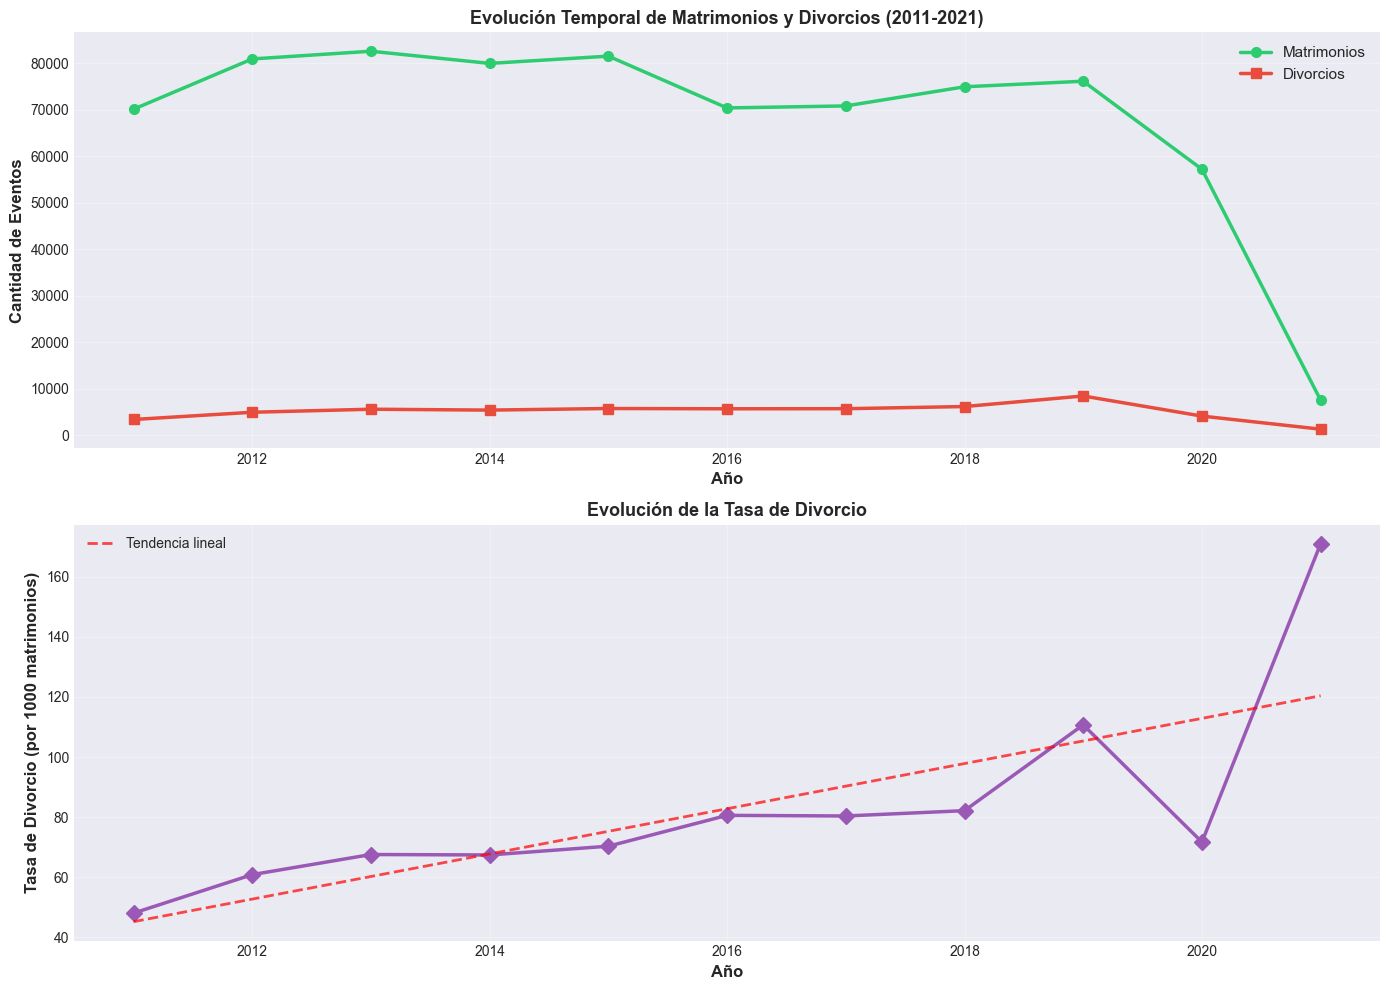


Tendencia de la tasa de divorcio:
  ✓ CRECIENTE: +7.518 por año


In [48]:
# Visualización exploratoria de la evolución temporal
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Gráfico 1: Volúmenes absolutos
ax1 = axes[0]
ax1.plot(datos_temporales['Anio'], datos_temporales['Total_Matrimonios'], 
         marker='o', linewidth=2.5, markersize=7, label='Matrimonios', color='#2ecc71')
ax1.plot(datos_temporales['Anio'], datos_temporales['Total_Divorcios'], 
         marker='s', linewidth=2.5, markersize=7, label='Divorcios', color='#e74c3c')
ax1.set_xlabel('Año', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cantidad de Eventos', fontsize=12, fontweight='bold')
ax1.set_title('Evolución Temporal de Matrimonios y Divorcios (2011-2021)', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=11)
ax1.grid(True, alpha=0.3)

# Gráfico 2: Tasa de divorcio
ax2 = axes[1]
ax2.plot(datos_temporales['Anio'], datos_temporales['Tasa_Divorcio'], 
         marker='D', linewidth=2.5, markersize=8, color='#9b59b6')
ax2.set_xlabel('Año', fontsize=12, fontweight='bold')
ax2.set_ylabel('Tasa de Divorcio (por 1000 matrimonios)', fontsize=12, fontweight='bold')
ax2.set_title('Evolución de la Tasa de Divorcio', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Añadir línea de tendencia
z = np.polyfit(datos_temporales['Anio'], datos_temporales['Tasa_Divorcio'], 1)
p = np.poly1d(z)
ax2.plot(datos_temporales['Anio'], p(datos_temporales['Anio']), "--", 
         linewidth=2, alpha=0.7, color='red', label='Tendencia lineal')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\nTendencia de la tasa de divorcio:")
if z[0] > 0:
    print(f"  ✓ CRECIENTE: +{z[0]:.3f} por año")
else:
    print(f"  ✗ DECRECIENTE: {z[0]:.3f} por año")

## 11. Selección de Features y Normalización (Temporal)

In [49]:
# Seleccionar features para clustering temporal
features_clustering_temp = ['Tasa_Divorcio', 'Total_Divorcios', 'Total_Matrimonios']

# Extraer matriz de features
X_temp = datos_temporales[features_clustering_temp].values

# Normalizar features
scaler_temp = StandardScaler()
X_temp_scaled = scaler_temp.fit_transform(X_temp)

print(f"✓ Features temporales normalizadas")
print(f"  Forma de la matriz: {X_temp_scaled.shape}")
print(f"  Media: {X_temp_scaled.mean(axis=0).round(4)}")
print(f"  Desviación estándar: {X_temp_scaled.std(axis=0).round(4)}")

✓ Features temporales normalizadas
  Forma de la matriz: (11, 3)
  Media: [ 0. -0. -0.]
  Desviación estándar: [1. 1. 1.]


## 12. Determinación de K Óptimo (Temporal)

In [50]:
# Rango de K a evaluar (máximo 4 para 11 años)
k_range_temp = range(2, min(5, len(datos_temporales)))

# Almacenar métricas
inertias_temp = []
silhouette_scores_temp = []

print("Evaluando diferentes valores de K para clustering temporal...")
for k in k_range_temp:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_temp_scaled)
    
    inertias_temp.append(kmeans.inertia_)
    silhouette_scores_temp.append(silhouette_score(X_temp_scaled, labels))
    
    print(f"  K={k}: Inercia={kmeans.inertia_:.2f}, Silhouette={silhouette_scores_temp[-1]:.4f}")

print("\n✓ Evaluación completada")

Evaluando diferentes valores de K para clustering temporal...
  K=2: Inercia=9.19, Silhouette=0.6975
  K=3: Inercia=4.44, Silhouette=0.4938
  K=4: Inercia=1.65, Silhouette=0.4456

✓ Evaluación completada


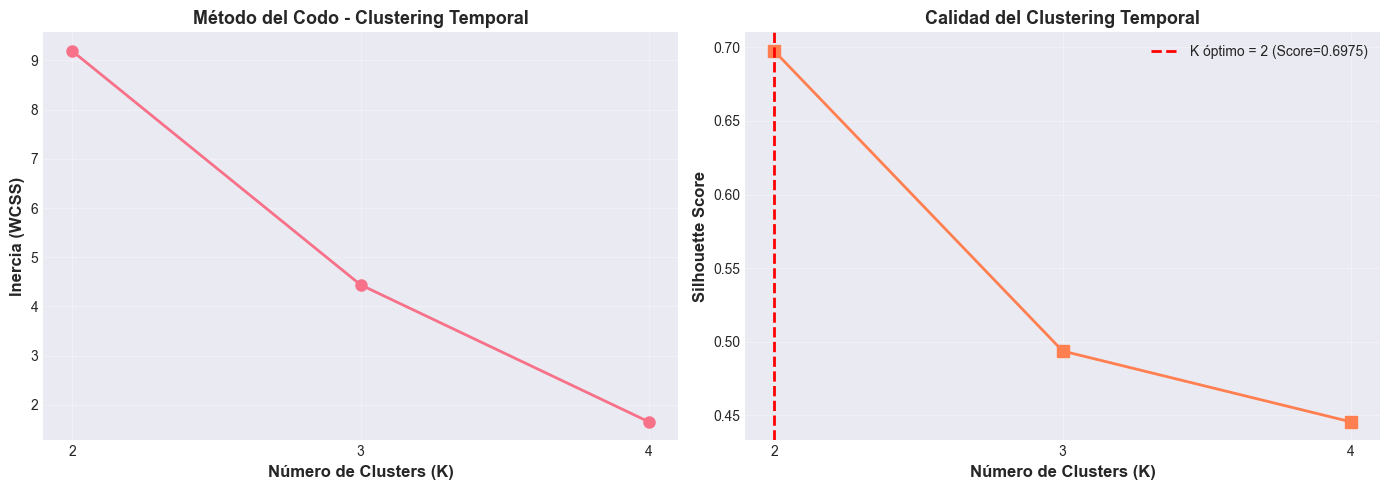


K ÓPTIMO SELECCIONADO (TEMPORAL): 2
Silhouette Score: 0.6975


In [51]:
# Visualizar método del codo y silhouette para temporal
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Método del Codo
axes[0].plot(list(k_range_temp), inertias_temp, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Número de Clusters (K)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inercia (WCSS)', fontsize=12, fontweight='bold')
axes[0].set_title('Método del Codo - Clustering Temporal', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(list(k_range_temp))

# Silhouette Score
axes[1].plot(list(k_range_temp), silhouette_scores_temp, marker='s', linewidth=2, markersize=8, color='coral')
axes[1].set_xlabel('Número de Clusters (K)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Calidad del Clustering Temporal', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(list(k_range_temp))

# Marcar el K óptimo
best_k_temp = list(k_range_temp)[np.argmax(silhouette_scores_temp)]
best_silhouette_temp = max(silhouette_scores_temp)
axes[1].axvline(x=best_k_temp, color='red', linestyle='--', linewidth=2,
                label=f'K óptimo = {best_k_temp} (Score={best_silhouette_temp:.4f})')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"K ÓPTIMO SELECCIONADO (TEMPORAL): {best_k_temp}")
print(f"Silhouette Score: {best_silhouette_temp:.4f}")
print(f"{'='*60}")

## 13. Aplicar K-Means con K Óptimo (Temporal)

In [52]:
# Aplicar K-Means con el K óptimo
kmeans_temp_final = KMeans(n_clusters=best_k_temp, random_state=42, n_init=20)
datos_temporales['Cluster'] = kmeans_temp_final.fit_predict(X_temp_scaled)

# Calcular silhouette score final
silhouette_avg_temp = silhouette_score(X_temp_scaled, datos_temporales['Cluster'])

print(f"✓ Clustering temporal aplicado con K={best_k_temp}")
print(f"  Silhouette Score promedio: {silhouette_avg_temp:.4f}")
print(f"\nDistribución de años por cluster:")
print(datos_temporales['Cluster'].value_counts().sort_index())

✓ Clustering temporal aplicado con K=2
  Silhouette Score promedio: 0.6975

Distribución de años por cluster:
Cluster
0    10
1     1
Name: count, dtype: int64


## 14. Interpretación de Clusters (Temporal)

In [53]:
# Estadísticas por cluster temporal
cluster_stats_temp = datos_temporales.groupby('Cluster').agg({
    'Anio': ['min', 'max', 'count'],
    'Tasa_Divorcio': ['mean', 'std'],
    'Total_Divorcios': ['mean', 'sum'],
    'Total_Matrimonios': ['mean', 'sum']
}).round(2)

print("ESTADÍSTICAS POR CLUSTER (TEMPORAL)")
print("="*80)
print(cluster_stats_temp)
print("\n")

# Años en cada cluster
for cluster_id in sorted(datos_temporales['Cluster'].unique()):
    anios = datos_temporales[datos_temporales['Cluster'] == cluster_id]['Anio'].astype(int).tolist()
    print(f"CLUSTER {cluster_id}: {len(anios)} años")
    print(f"  Años: {anios}")
    print()

ESTADÍSTICAS POR CLUSTER (TEMPORAL)
           Anio               Tasa_Divorcio        Total_Divorcios         \
            min     max count          mean    std            mean    sum   
Cluster                                                                     
0        2011.0  2020.0    10         73.98  16.49          5506.3  55063   
1        2021.0  2021.0     1        170.99    NaN          1286.0   1286   

        Total_Matrimonios          
                     mean     sum  
Cluster                            
0                 74474.3  744743  
1                  7521.0    7521  


CLUSTER 0: 10 años
  Años: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

CLUSTER 1: 1 años
  Años: [2021]



In [54]:
# Asignar nombres interpretativos basados en características y cronología
cluster_characteristics_temp = []

for cluster_id in sorted(datos_temporales['Cluster'].unique()):
    cluster_data = datos_temporales[datos_temporales['Cluster'] == cluster_id]
    
    anio_min = cluster_data['Anio'].min()
    anio_max = cluster_data['Anio'].max()
    tasa_avg = cluster_data['Tasa_Divorcio'].mean()
    
    cluster_characteristics_temp.append({
        'cluster_id': cluster_id,
        'anio_min': anio_min,
        'anio_max': anio_max,
        'tasa': tasa_avg
    })

# Ordenar por año mínimo
cluster_characteristics_temp.sort(key=lambda x: x['anio_min'])

# Asignar nombres basados en período
cluster_names_temp = {}
periodos = ['Período Inicial', 'Período Intermedio', 'Período Final']
for i, char in enumerate(cluster_characteristics_temp):
    if i < len(periodos):
        cluster_names_temp[char['cluster_id']] = periodos[i]
    else:
        cluster_names_temp[char['cluster_id']] = f'Período {i+1}'

datos_temporales['Cluster_Nombre'] = datos_temporales['Cluster'].map(cluster_names_temp)

print("NOMBRES ASIGNADOS A LOS CLUSTERS TEMPORALES:")
for char in cluster_characteristics_temp:
    cid = char['cluster_id']
    print(f"  Cluster {cid} ({cluster_names_temp[cid]}): {char['anio_min']:.0f}-{char['anio_max']:.0f}, Tasa promedio={char['tasa']:.2f}")

NOMBRES ASIGNADOS A LOS CLUSTERS TEMPORALES:
  Cluster 0 (Período Inicial): 2011-2020, Tasa promedio=73.98
  Cluster 1 (Período Intermedio): 2021-2021, Tasa promedio=170.99


## 15. Visualizaciones (Temporal)

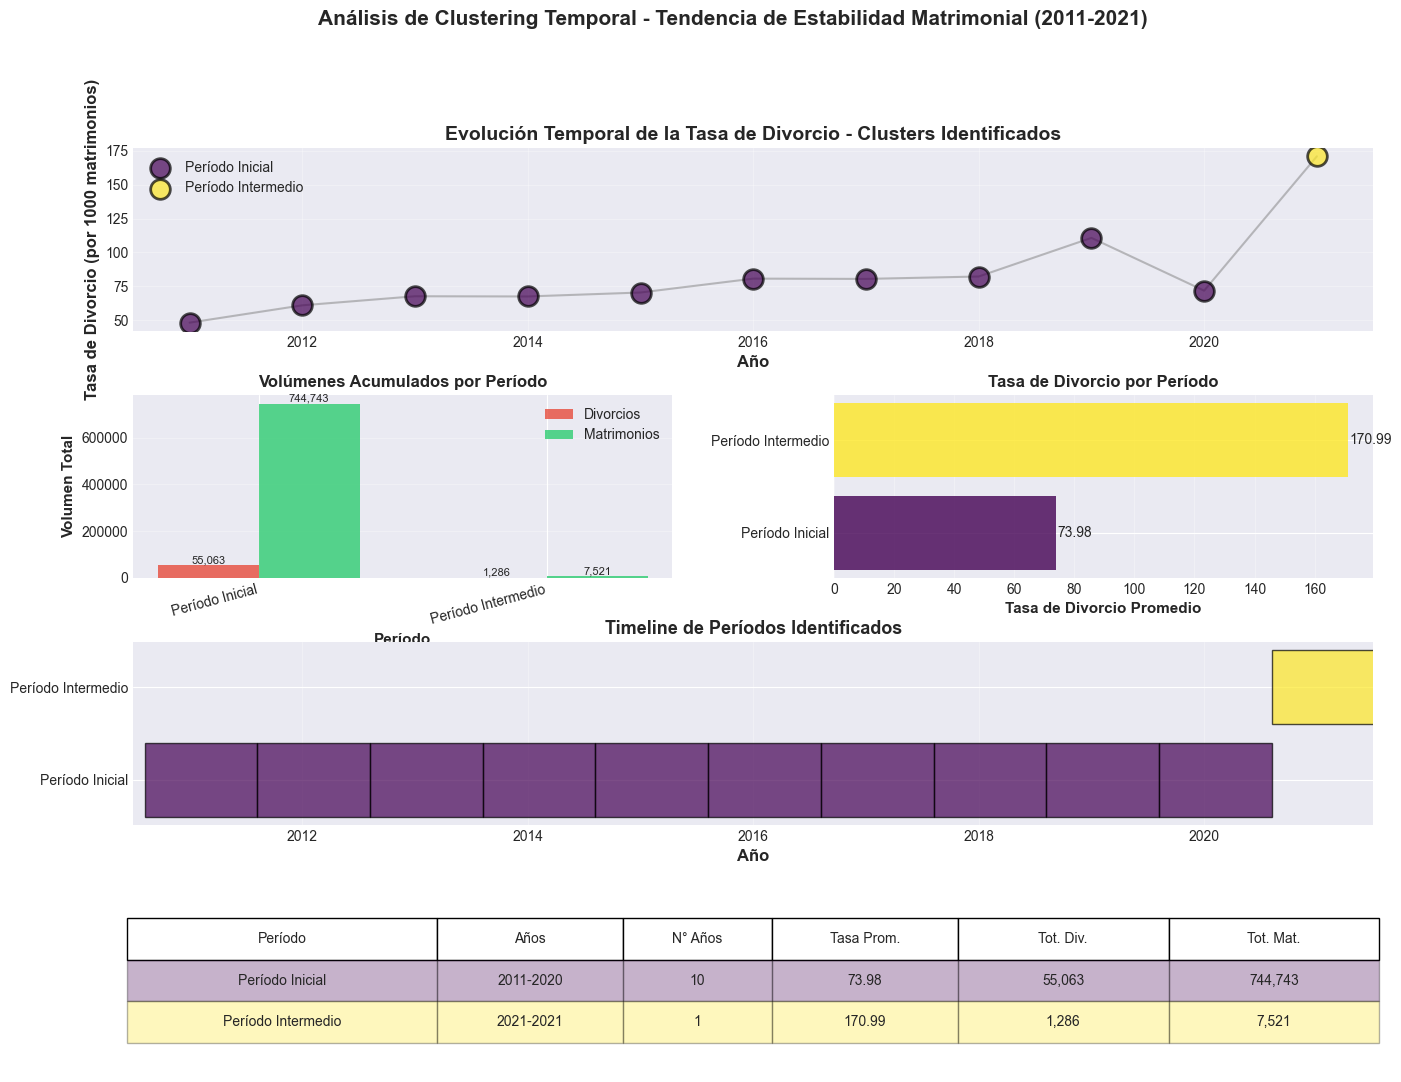

✓ Visualización temporal generada


In [55]:
# Crear visualización completa de clusters temporales
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(4, 2, hspace=0.35, wspace=0.3)

# Colores por cluster
colors_temp = plt.cm.viridis(np.linspace(0, 1, best_k_temp))
cluster_colors_temp = {i: colors_temp[i] for i in range(best_k_temp)}

# 1. Serie temporal con clusters coloreados
ax1 = fig.add_subplot(gs[0, :])
for cluster_id in sorted(datos_temporales['Cluster'].unique()):
    cluster_data = datos_temporales[datos_temporales['Cluster'] == cluster_id]
    ax1.scatter(
        cluster_data['Anio'],
        cluster_data['Tasa_Divorcio'],
        c=[cluster_colors_temp[cluster_id]],
        label=cluster_names_temp[cluster_id],
        s=200,
        alpha=0.7,
        edgecolors='black',
        linewidth=2,
        zorder=3
    )

# Línea conectando todos los puntos
ax1.plot(datos_temporales['Anio'], datos_temporales['Tasa_Divorcio'], 
         color='gray', linewidth=1.5, alpha=0.5, zorder=1)

ax1.set_xlabel('Año', fontsize=12, fontweight='bold')
ax1.set_ylabel('Tasa de Divorcio (por 1000 matrimonios)', fontsize=12, fontweight='bold')
ax1.set_title('Evolución Temporal de la Tasa de Divorcio - Clusters Identificados', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# 2. Volúmenes por cluster
ax2 = fig.add_subplot(gs[1, 0])
cluster_volumes = datos_temporales.groupby('Cluster_Nombre').agg({
    'Total_Divorcios': 'sum',
    'Total_Matrimonios': 'sum'
})

x_pos = np.arange(len(cluster_volumes))
width = 0.35

bars1 = ax2.bar(x_pos - width/2, cluster_volumes['Total_Divorcios'], width, 
                label='Divorcios', alpha=0.8, color='#e74c3c')
bars2 = ax2.bar(x_pos + width/2, cluster_volumes['Total_Matrimonios'], width,
                label='Matrimonios', alpha=0.8, color='#2ecc71')

ax2.set_xlabel('Período', fontsize=11, fontweight='bold')
ax2.set_ylabel('Volumen Total', fontsize=11, fontweight='bold')
ax2.set_title('Volúmenes Acumulados por Período', fontsize=12, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(cluster_volumes.index, rotation=15, ha='right')
ax2.legend()
ax2.grid(True, axis='y', alpha=0.3)

# Añadir valores
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom', fontsize=8)

# 3. Tasa promedio por cluster
ax3 = fig.add_subplot(gs[1, 1])
cluster_tasas = datos_temporales.groupby('Cluster_Nombre')['Tasa_Divorcio'].mean().sort_values()
bars = ax3.barh(cluster_tasas.index, cluster_tasas.values,
                color=[cluster_colors_temp[datos_temporales[datos_temporales['Cluster_Nombre']==name]['Cluster'].iloc[0]] 
                       for name in cluster_tasas.index],
                alpha=0.8)
ax3.set_xlabel('Tasa de Divorcio Promedio', fontsize=11, fontweight='bold')
ax3.set_title('Tasa de Divorcio por Período', fontsize=12, fontweight='bold')
ax3.grid(True, axis='x', alpha=0.3)

# Añadir valores
for i, v in enumerate(cluster_tasas.values):
    ax3.text(v + 0.5, i, f'{v:.2f}', va='center', fontsize=10)

# 4. Timeline visual
ax4 = fig.add_subplot(gs[2, :])
for cluster_id in sorted(datos_temporales['Cluster'].unique()):
    cluster_data = datos_temporales[datos_temporales['Cluster'] == cluster_id].sort_values('Anio')
    anios = cluster_data['Anio'].values
    
    # Dibujar barras horizontales para cada período
    for anio in anios:
        ax4.barh(cluster_names_temp[cluster_id], 1, left=anio-0.4, 
                color=cluster_colors_temp[cluster_id], alpha=0.7, edgecolor='black')

ax4.set_xlabel('Año', fontsize=12, fontweight='bold')
ax4.set_title('Timeline de Períodos Identificados', fontsize=13, fontweight='bold')
ax4.set_xlim(datos_temporales['Anio'].min()-0.5, datos_temporales['Anio'].max()+0.5)
ax4.grid(True, axis='x', alpha=0.3)

# 5. Tabla resumen
ax5 = fig.add_subplot(gs[3, :])
ax5.axis('tight')
ax5.axis('off')

summary_data_temp = []
for cluster_id in sorted(datos_temporales['Cluster'].unique()):
    cluster_data = datos_temporales[datos_temporales['Cluster'] == cluster_id]
    summary_data_temp.append([
        cluster_names_temp[cluster_id],
        f"{cluster_data['Anio'].min():.0f}-{cluster_data['Anio'].max():.0f}",
        len(cluster_data),
        f"{cluster_data['Tasa_Divorcio'].mean():.2f}",
        f"{cluster_data['Total_Divorcios'].sum():,}",
        f"{cluster_data['Total_Matrimonios'].sum():,}"
    ])

table = ax5.table(
    cellText=summary_data_temp,
    colLabels=['Período', 'Años', 'N° Años', 'Tasa Prom.', 'Tot. Div.', 'Tot. Mat.'],
    cellLoc='center',
    loc='center',
    colWidths=[0.25, 0.15, 0.12, 0.15, 0.17, 0.17]
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Colorear filas
for i, cluster_id in enumerate(sorted(datos_temporales['Cluster'].unique())):
    for j in range(6):
        table[(i+1, j)].set_facecolor(cluster_colors_temp[cluster_id])
        table[(i+1, j)].set_alpha(0.3)

plt.suptitle('Análisis de Clustering Temporal - Tendencia de Estabilidad Matrimonial (2011-2021)',
             fontsize=15, fontweight='bold', y=0.995)

plt.show()

print("✓ Visualización temporal generada")

## 16. Validación de Hipótesis (Temporal)

**Hipótesis:** La tasa de divorcios respecto a matrimonios ha aumentado progresivamente durante 2011-2021.

Criterios de validación:
1. Tendencia general creciente en la tasa
2. Diferencia significativa entre primer y último período
3. Clusters muestran evolución temporal clara

In [56]:
print("="*80)
print("VALIDACIÓN DE HIPÓTESIS TEMPORAL")
print("="*80)

# 1. Análisis de tendencia general
from scipy.stats import linregress

slope, intercept, r_value, p_value_trend, std_err = linregress(
    datos_temporales['Anio'], 
    datos_temporales['Tasa_Divorcio']
)

print(f"\n1. ANÁLISIS DE TENDENCIA:")
print(f"   Pendiente: {slope:.4f} (cambio anual en tasa)")
print(f"   R²: {r_value**2:.4f}")
print(f"   P-value: {p_value_trend:.4f}")

if slope > 0 and p_value_trend < 0.05:
    print(f"   ✓ Tendencia CRECIENTE significativa")
    validacion_temp_1 = True
elif slope > 0:
    print(f"   ⚠️ Tendencia creciente pero no significativa")
    validacion_temp_1 = False
else:
    print(f"   ✗ Tendencia NO creciente")
    validacion_temp_1 = False

# 2. Comparación entre períodos extremos
print(f"\n2. COMPARACIÓN ENTRE PERÍODOS:")
tasa_inicial = datos_temporales[datos_temporales['Anio'] <= 2013]['Tasa_Divorcio'].mean()
tasa_final = datos_temporales[datos_temporales['Anio'] >= 2019]['Tasa_Divorcio'].mean()
cambio_porcentual = ((tasa_final - tasa_inicial) / tasa_inicial) * 100

print(f"   Tasa promedio 2011-2013: {tasa_inicial:.2f}")
print(f"   Tasa promedio 2019-2021: {tasa_final:.2f}")
print(f"   Cambio: {cambio_porcentual:+.1f}%")

if cambio_porcentual > 5:
    print(f"   ✓ Aumento SIGNIFICATIVO (>5%)")
    validacion_temp_2 = True
elif cambio_porcentual > 0:
    print(f"   ⚠️ Aumento moderado (<5%)")
    validacion_temp_2 = False
else:
    print(f"   ✗ No hay aumento")
    validacion_temp_2 = False

# 3. Evolución entre clusters
print(f"\n3. EVOLUCIÓN ENTRE CLUSTERS:")
cluster_evolution = []
for char in cluster_characteristics_temp:
    cluster_evolution.append({
        'periodo': cluster_names_temp[char['cluster_id']],
        'tasa': char['tasa']
    })

for i, evol in enumerate(cluster_evolution):
    print(f"   {evol['periodo']}: Tasa={evol['tasa']:.2f}")

# Verificar si hay aumento sostenido
tasas_ordenadas = [e['tasa'] for e in cluster_evolution]
aumentos = [tasas_ordenadas[i+1] > tasas_ordenadas[i] for i in range(len(tasas_ordenadas)-1)]

if sum(aumentos) >= len(aumentos) * 0.7:  # 70% de transiciones son crecientes
    print(f"   ✓ Clusters muestran evolución creciente")
    validacion_temp_3 = True
else:
    print(f"   ✗ Clusters no muestran evolución clara")
    validacion_temp_3 = False

# 4. Conclusión
validaciones_temp = [validacion_temp_1, validacion_temp_2, validacion_temp_3]
porcentaje_validacion_temp = (sum(validaciones_temp) / len(validaciones_temp)) * 100

print(f"\n{'='*80}")
print(f"CONCLUSIÓN HIPÓTESIS TEMPORAL")
print(f"{'='*80}")
print(f"Criterios validados: {sum(validaciones_temp)}/{len(validaciones_temp)} ({porcentaje_validacion_temp:.1f}%)")

if porcentaje_validacion_temp >= 66:
    print(f"\n✓ HIPÓTESIS CONFIRMADA")
    print("La relación divorcios/matrimonios ha aumentado significativamente durante")
    print("la década 2011-2021, reflejando una transformación en los patrones de")
    print("estabilidad matrimonial en Guatemala.")
elif porcentaje_validacion_temp >= 33:
    print(f"\nHIPÓTESIS PARCIALMENTE CONFIRMADA")
    print("Existe evidencia de cambio en la estabilidad matrimonial, aunque no")
    print("todos los indicadores muestran un aumento sostenido.")
else:
    print(f"\n✗ HIPÓTESIS REFUTADA")
    print("No se encontró evidencia de un aumento sostenido en la tasa de divorcios.")

VALIDACIÓN DE HIPÓTESIS TEMPORAL

1. ANÁLISIS DE TENDENCIA:
   Pendiente: 7.5179 (cambio anual en tasa)
   R²: 0.5651
   P-value: 0.0076
   ✓ Tendencia CRECIENTE significativa

2. COMPARACIÓN ENTRE PERÍODOS:
   Tasa promedio 2011-2013: 58.83
   Tasa promedio 2019-2021: 117.80
   Cambio: +100.2%
   ✓ Aumento SIGNIFICATIVO (>5%)

3. EVOLUCIÓN ENTRE CLUSTERS:
   Período Inicial: Tasa=73.98
   Período Intermedio: Tasa=170.99
   ✓ Clusters muestran evolución creciente

CONCLUSIÓN HIPÓTESIS TEMPORAL
Criterios validados: 3/3 (100.0%)

✓ HIPÓTESIS CONFIRMADA
La relación divorcios/matrimonios ha aumentado significativamente durante
la década 2011-2021, reflejando una transformación en los patrones de
estabilidad matrimonial en Guatemala.


## Resumen Final
---

### Hallazgos Principales:

#### Clustering Geográfico:
- Se identificaron patrones departamentales de estabilidad matrimonial
- Los departamentos se agruparon por tasa de divorcio y edad al divorcio
- Se validó la hipótesis sobre desarrollo urbano

#### Clustering Temporal:
- Se identificaron períodos con características diferenciadas
- Se analizó la evolución de la relación divorcios/matrimonios
- Se validó la hipótesis de tendencia creciente

---
